In [ ]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from scipy.spatial import cKDTree
import gc
import glob
import os
import time

In [ ]:
 # Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the combined fire weather data
fire_weather_combined = pd.read_csv('/content/drive/MyDrive/0.Data science final project/3. Fire Weather combined/fire_weather_combined.csv')

In [ ]:
fire_weather_combined.head()

,latitude,longitude,brightness,scan,track,date,satellite,instrument,confidence,bright_t31,frp,daynight,type,frp_brightness_ratio,day_of_week,time,scaled_date,era5_eastward_wind,era5_northward_wind,era5_temperature
0,36.28835,-120.25271,298.26,0.42,0.45,2024-03-10,SUOMI,VIIRS,n,269.44,0.80,N,Presumed Vegetation Fire,0.002682,Sunday,9,1710.0288,1.680047,0.027381,283.043218
1,36.27491,-120.24533,304.08,0.42,0.45,2024-03-10,SUOMI,VIIRS,n,270.10,0.89,N,Presumed Vegetation Fire,0.002927,Sunday,9,1710.0288,1.702749,-0.024451,283.133987
2,36.27073,-120.24596,301.97,0.42,0.45,2024-03-10,SUOMI,VIIRS,n,268.92,0.89,N,Presumed Vegetation Fire,0.002947,Sunday,9,1710.0288,1.705211,-0.041117,283.167529
3,34.62195,-117.10254,310.34,0.43,0.38,2024-03-10,SUOMI,VIIRS,n,280.16,1.33,N,Presumed Vegetation Fire,0.004286,Sunday,9,1710.0288,0.808463,1.644761,279.078563
4,34.60886,-117.33659,308.74,0.44,0.39,2024-03-10,SUOMI,VIIRS,n,280.24,1.39,N,Presumed Vegetation Fire,0.004502,Sunday,9,1710.0288,0.940573,1.826032,278.963517


In [ ]:
# Load the terrain dataset - Change the name of the dataset according to the file that is being read
terrain_data = pd.read_csv('/content/drive/MyDrive/0.Data science final project/4. Terrain data/Latlon data/chunk_r4_c4_latlon.csv') #<------------------------CHANGE THIS

In [ ]:
terrain_data.head()

,x,y,elevation,slope,aspect
0,-116.199797,35.434761,NaN,NaN,NaN
1,-116.199473,35.434759,NaN,NaN,NaN
2,-116.199149,35.434757,NaN,NaN,NaN
3,-116.198825,35.434755,NaN,NaN,NaN
4,-116.198501,35.434752,NaN,NaN,NaN


In [ ]:
terrain_data.describe()

,x,y,elevation,slope,aspect
count,9.282560e+07,9.282560e+07,8.893652e+07,8.889629e+07,8.679980e+07
mean,-1.150787e+02,3.370365e+01,4.231185e+02,5.461233e+00,1.758132e+02
std,6.568516e-01,9.909529e-01,3.982645e+02,7.083529e+00,1.014182e+02
min,-1.162310e+02,3.196751e+01,-9.000000e+01,0.000000e+00,0.000000e+00
25%,-1.156474e+02,3.284553e+01,1.030000e+02,1.460969e+00,9.000000e+01
50%,-1.150788e+02,3.370374e+01,3.170000e+02,2.688098e+00,1.800000e+02
75%,-1.145105e+02,3.456182e+01,6.390000e+02,5.630848e+00,2.618699e+02
max,-1.138798e+02,3.543476e+01,2.267000e+03,7.810040e+01,3.598975e+02


In [ ]:
# Check for null values in the terrain dataset
terrain_data.isnull().sum()

,0
x,0
y,0
elevation,3889077
slope,3929309
aspect,6025797


In [ ]:
# Remove rows where there are null values
terrain_data = terrain_data.dropna()

In [ ]:
# rename columns, x is longitude, and y is latitude
terrain_data.rename(columns={'x': 'longitude', 'y': 'latitude'}, inplace=True)

<ipython-input-94-fcd2975bb2e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terrain_data.rename(columns={'x': 'longitude', 'y': 'latitude'}, inplace=True)


In [ ]:
terrain_data.isnull().sum()

,0
longitude,0
latitude,0
elevation,0
slope,0
aspect,0


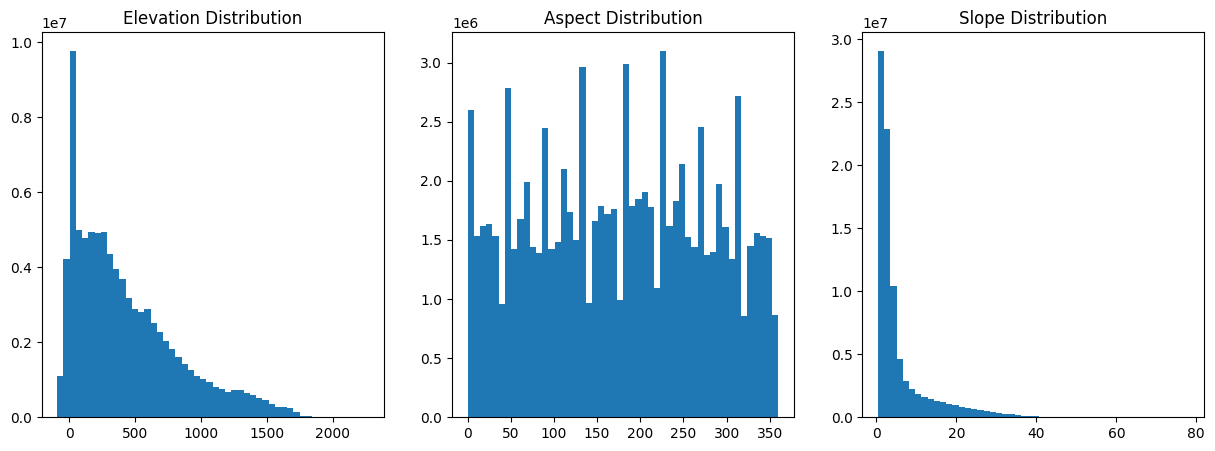

In [ ]:
# Plot a histogram to visualise the elevation, aspect and slope data distribution
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(terrain_data['elevation'], bins=50)
axs[0].set_title('Elevation Distribution')
axs[1].hist(terrain_data['aspect'], bins=50)
axs[1].set_title('Aspect Distribution')
axs[2].hist(terrain_data['slope'], bins=50)
axs[2].set_title('Slope Distribution')
plt.show()

In [ ]:
# Find the min and max coordinates of the terrain dataset
min_lat = terrain_data['latitude'].min()
max_lat = terrain_data['latitude'].max()
min_lon = terrain_data['longitude'].min()
max_lon = terrain_data['longitude'].max()

In [ ]:
# Filter the fire weather data according to the min max coordinates of the terrain dataset
filtered_fire_weather = fire_weather_combined[(fire_weather_combined['latitude'] >= min_lat) & (fire_weather_combined['latitude'] <= max_lat) & (fire_weather_combined['longitude'] >= min_lon) & (fire_weather_combined['longitude'] <= max_lon)]

In [ ]:
# Create IDW function
def calculate_idw(filtered_fire_weather, terrain_data, num_neighbors=4, power=2):
    """Calculates IDW for terrain features and adds them to fire weather data."""

    tree = cKDTree(np.column_stack((terrain_data['latitude'], terrain_data['longitude'])))

    for col in ['elevation', 'slope', 'aspect']:
        filtered_fire_weather[f'terrain_{col}'] = np.nan  # Initialize new column

        for i, row in filtered_fire_weather.iterrows():
            distances, indices = tree.query(
                np.array([[row['latitude'], row['longitude']]]), k=num_neighbors
            )
            distances = distances[0]
            indices = indices[0]

            weights = 1 / (distances ** power)
            weights = np.where(np.isinf(distances), 0, weights)
            weighted_sum = np.sum(terrain_data[col].values[indices] * weights)
            total_weight = np.sum(weights)

            if total_weight > 0:
                filtered_fire_weather.loc[i, f'terrain_{col}'] = weighted_sum / total_weight

            if (i + 1) % 100 == 0:
                print(f'Processing fire event {i + 1} of {len(filtered_fire_weather)} for {col}')

    return filtered_fire_weather

# --- Perform IDW ---
if not filtered_fire_weather.empty:
    start_time = time.time()  # Start timer

    result_df = calculate_idw(filtered_fire_weather, terrain_data)

    end_time = time.time()  # End timer
    elapsed_time = end_time - start_time

    # --- Save to CSV ---
    output_dir = '/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/IDW results'
    os.makedirs(output_dir, exist_ok=True)

    output_filename = 'r4_c4_results.csv' #<-------------------------------------------------------- CHANGE
    output_filepath = os.path.join(output_dir, output_filename)

    result_df.to_csv(output_filepath, index=False)

    print(f"Results saved to: {output_filepath}")
    print(f"IDW calculation took: {elapsed_time:.2f} seconds")

    # --- Clean up ---
    del terrain_data, filtered_fire_weather, result_df
    gc.collect()
else:
    print("No fire data within bounds of r4_c4_results.csv") #<-------------------------------------------------------- CHANGE
    del terrain_data, filtered_fire_weather
    gc.collect()

print("Processing complete.")

<ipython-input-99-5c0f9e18f927>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fire_weather[f'terrain_{col}'] = np.nan  # Initialize new column


Processing fire event 2800 of 6671 for elevation
Processing fire event 3800 of 6671 for elevation
Processing fire event 8400 of 6671 for elevation
Processing fire event 13200 of 6671 for elevation
Processing fire event 14200 of 6671 for elevation
Processing fire event 14900 of 6671 for elevation
Processing fire event 40300 of 6671 for elevation
Processing fire event 65200 of 6671 for elevation
Processing fire event 67800 of 6671 for elevation
Processing fire event 77900 of 6671 for elevation
Processing fire event 86000 of 6671 for elevation
Processing fire event 134800 of 6671 for elevation
Processing fire event 143800 of 6671 for elevation
Processing fire event 144800 of 6671 for elevation
Processing fire event 149800 of 6671 for elevation
Processing fire event 151700 of 6671 for elevation
Processing fire event 155500 of 6671 for elevation
Processing fire event 158000 of 6671 for elevation
Processing fire event 158400 of 6671 for elevation
Processing fire event 165100 of 6671 for elev

<ipython-input-99-5c0f9e18f927>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fire_weather[f'terrain_{col}'] = np.nan  # Initialize new column


Processing fire event 2800 of 6671 for slope
Processing fire event 3800 of 6671 for slope
Processing fire event 8400 of 6671 for slope
Processing fire event 13200 of 6671 for slope
Processing fire event 14200 of 6671 for slope
Processing fire event 14900 of 6671 for slope
Processing fire event 40300 of 6671 for slope
Processing fire event 65200 of 6671 for slope
Processing fire event 67800 of 6671 for slope
Processing fire event 77900 of 6671 for slope
Processing fire event 86000 of 6671 for slope
Processing fire event 134800 of 6671 for slope
Processing fire event 143800 of 6671 for slope
Processing fire event 144800 of 6671 for slope
Processing fire event 149800 of 6671 for slope
Processing fire event 151700 of 6671 for slope
Processing fire event 155500 of 6671 for slope
Processing fire event 158000 of 6671 for slope
Processing fire event 158400 of 6671 for slope
Processing fire event 165100 of 6671 for slope
Processing fire event 197300 of 6671 for slope
Processing fire event 20150

<ipython-input-99-5c0f9e18f927>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fire_weather[f'terrain_{col}'] = np.nan  # Initialize new column


Processing fire event 8400 of 6671 for aspect
Processing fire event 13200 of 6671 for aspect
Processing fire event 14200 of 6671 for aspect
Processing fire event 14900 of 6671 for aspect
Processing fire event 40300 of 6671 for aspect
Processing fire event 65200 of 6671 for aspect
Processing fire event 67800 of 6671 for aspect
Processing fire event 77900 of 6671 for aspect
Processing fire event 86000 of 6671 for aspect
Processing fire event 134800 of 6671 for aspect
Processing fire event 143800 of 6671 for aspect
Processing fire event 144800 of 6671 for aspect
Processing fire event 149800 of 6671 for aspect
Processing fire event 151700 of 6671 for aspect
Processing fire event 155500 of 6671 for aspect
Processing fire event 158000 of 6671 for aspect
Processing fire event 158400 of 6671 for aspect
Processing fire event 165100 of 6671 for aspect
Processing fire event 197300 of 6671 for aspect
Processing fire event 201500 of 6671 for aspect
Processing fire event 203800 of 6671 for aspect
Pr

In [ ]:
# Get stats info about the computed dataset
result = pd.read_csv('/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/IDW results/r4_c4_results.csv') #<-------------------------------------------------------- CHANGE

In [ ]:
result.head()

,latitude,longitude,brightness,scan,track,date,satellite,instrument,confidence,bright_t31,...,frp_brightness_ratio,day_of_week,time,scaled_date,era5_eastward_wind,era5_northward_wind,era5_temperature,terrain_elevation,terrain_slope,terrain_aspect
0,32.60605,-114.62547,353.53,0.55,0.51,2024-03-12,SUOMI,VIIRS,n,312.39,...,0.141600,Tuesday,20,1710.2016,2.199341,-1.586145,296.696960,60.693037,1.810670,126.836847
1,32.60209,-114.62659,341.24,0.55,0.51,2024-03-12,SUOMI,VIIRS,n,302.43,...,0.028074,Tuesday,20,1710.2016,2.192860,-1.587124,296.698169,61.949020,1.475408,21.706578
2,32.60803,-114.62227,341.34,0.55,0.51,2024-03-12,SUOMI,VIIRS,n,304.08,...,0.148503,Tuesday,20,1710.2016,2.204240,-1.581175,296.694415,59.352236,0.978814,253.513394
3,33.26195,-115.57259,355.49,0.60,0.53,2024-03-12,SUOMI,VIIRS,n,302.65,...,0.104869,Tuesday,20,1710.2016,2.444774,-0.731370,294.830173,-63.000000,0.944778,102.563214
4,33.26048,-115.57897,336.35,0.60,0.53,2024-03-12,SUOMI,VIIRS,n,298.70,...,0.022031,Tuesday,20,1710.2016,2.381002,-0.756817,294.817451,-66.000000,0.524585,124.815725


In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6671 entries, 0 to 6670
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   latitude              6671 non-null   float64
 1   longitude             6671 non-null   float64
 2   brightness            6671 non-null   float64
 3   scan                  6671 non-null   float64
 4   track                 6671 non-null   float64
 5   date                  6671 non-null   object 
 6   satellite             6671 non-null   object 
 7   instrument            6671 non-null   object 
 8   confidence            6671 non-null   object 
 9   bright_t31            6671 non-null   float64
 10  frp                   6671 non-null   float64
 11  daynight              6671 non-null   object 
 12  type                  6671 non-null   object 
 13  frp_brightness_ratio  6671 non-null   float64
 14  day_of_week           6671 non-null   object 
 15  time                 

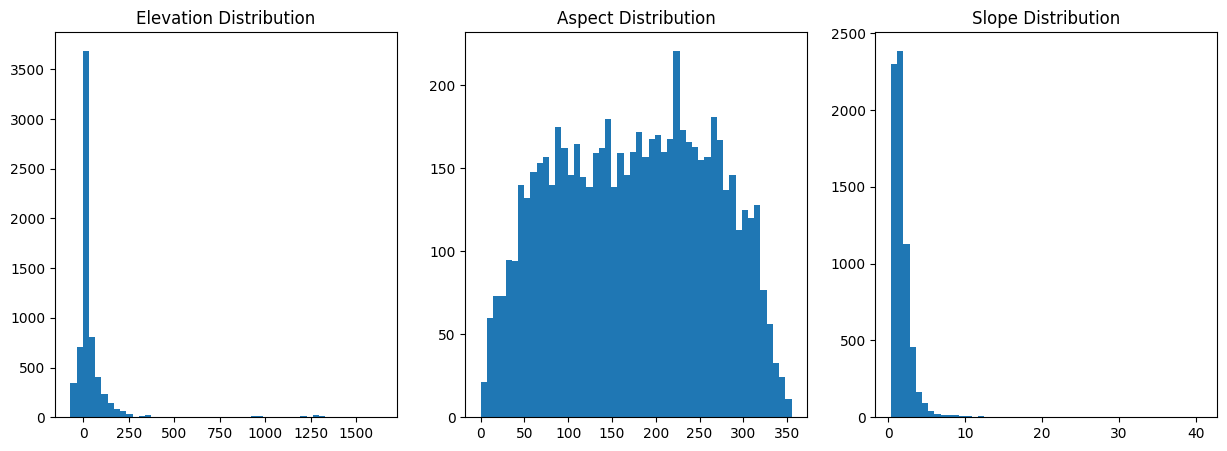

In [ ]:
# plot elevation, slope and aspect from the results dataset

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(result['terrain_elevation'], bins=50)
axs[0].set_title('Elevation Distribution')
axs[1].hist(result['terrain_aspect'], bins=50)
axs[1].set_title('Aspect Distribution')
axs[2].hist(result['terrain_slope'], bins=50)
axs[2].set_title('Slope Distribution')
plt.show()

In [ ]:
 # Concatenate all the results datasets computed into one
results_path = '/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/IDW results'
all_files = glob.glob(os.path.join(results_path, "r*_c*_results.csv"))
print(all_files)

['/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/IDW results/r0_c0_results.csv', '/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/IDW results/r0_c1_results.csv', '/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/IDW results/r0_c2_results.csv', '/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/IDW results/r0_c3_results.csv', '/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/IDW results/r0_c4_results.csv', '/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/IDW results/r1_c0_results.csv', '/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/IDW results/r1_c1_results.csv', '/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/IDW results/r1_c2_results.csv', '/content/drive/MyDrive/0.Data science final project/5.

In [ ]:
df_from_each_file = (pd.read_csv(f) for f in all_files)
fire_weather_terrain = pd.concat(df_from_each_file, ignore_index=True)

In [ ]:
# Save as a csv
fire_weather_terrain.to_csv('/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/fire_weather_terrain.csv', index=False)

In [ ]:
# Check a few values manually to see how interpolation has performed

# Target latitude and longitude
target_latitude = 47.74572
target_longitude = -114.51061

# Tolerance for floating-point comparison
tolerance = 1e-4

# Perform the lookup
result = terrain_data[
    (abs(terrain_data['y'] - target_latitude) <= tolerance) &
    (abs(terrain_data['x'] - target_longitude) <= tolerance)
]

# Display the result
if not result.empty:
    print(result)
else:
    print(f"No terrain data found for latitude {target_latitude}, longitude {target_longitude}.")

                   x          y  elevation      slope      aspect
30464427 -114.510567  47.745771     1400.0  18.518745  288.434937


In [ ]:
fire_weather_terrain.head()

,latitude,longitude,brightness,scan,track,date,satellite,instrument,confidence,bright_t31,...,frp_brightness_ratio,day_of_week,time,scaled_date,era5_eastward_wind,era5_northward_wind,era5_temperature,terrain_elevation,terrain_slope,terrain_aspect
0,48.62248,-123.53745,315.41,0.39,0.36,2024-03-12,SUOMI,VIIRS,n,276.92,...,0.005200,Tuesday,10,1710.2016,0.238112,1.836057,278.236472,141.053091,17.995291,277.745056
1,48.46122,-124.04675,336.03,0.39,0.36,2024-03-15,SUOMI,VIIRS,n,289.20,...,0.012975,Friday,20,1710.4608,-2.302568,-0.722024,282.733589,499.959241,11.635393,189.708092
2,48.46284,-124.04449,331.22,0.39,0.36,2024-03-15,SUOMI,VIIRS,n,290.66,...,0.010869,Friday,20,1710.4608,-2.337032,-0.728638,282.728811,534.427533,10.487661,189.553949
3,47.21657,-123.03061,326.83,0.39,0.36,2024-03-18,SUOMI,VIIRS,n,278.20,...,0.007037,Monday,10,1710.7200,0.260060,-1.021459,279.411684,41.047428,1.491172,29.854566
4,48.45983,-124.04285,333.52,0.47,0.48,2024-03-18,SUOMI,VIIRS,n,291.09,...,0.009445,Monday,21,1710.7200,-0.550469,0.047243,283.462244,481.502214,7.948330,237.428700


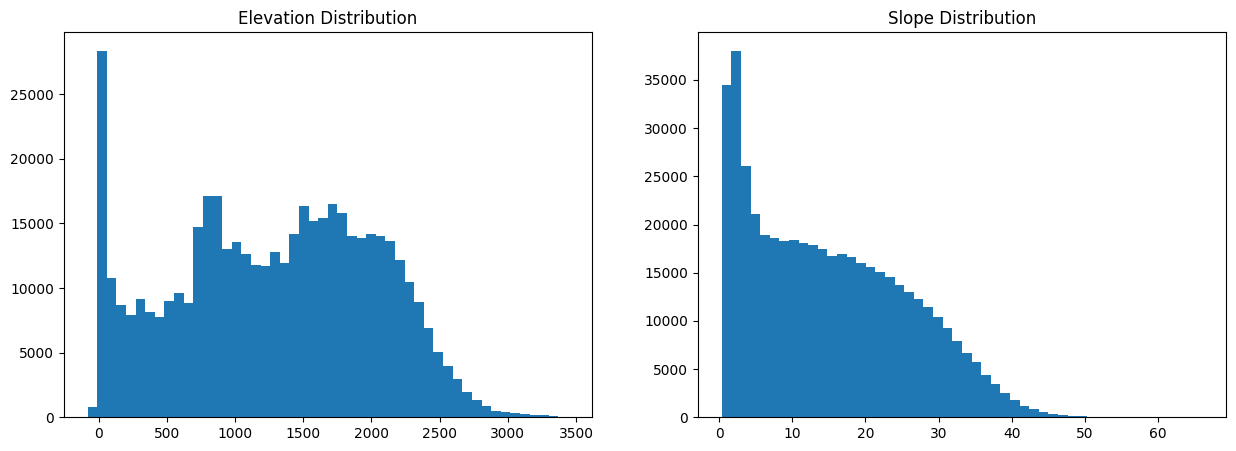

In [ ]:
#plot histogram to show distribution of elevation and slope
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(fire_weather_terrain['terrain_elevation'], bins=50)
axs[0].set_title('Elevation Distribution')
axs[1].hist(fire_weather_terrain['terrain_slope'], bins=50)
axs[1].set_title('Slope Distribution')
plt.show()

In [ ]:
fire_weather_terrain.describe()

,latitude,longitude,brightness,scan,track,bright_t31,frp,frp_brightness_ratio,time,scaled_date,era5_eastward_wind,era5_northward_wind,era5_temperature,terrain_elevation,terrain_slope,terrain_aspect
count,465195.000000,465195.000000,465195.000000,465195.000000,465195.000000,465195.000000,465195.000000,465195.000000,465195.000000,465195.000000,465195.000000,465195.000000,465195.000000,465195.000000,465195.000000,465195.000000
mean,41.904019,-118.856353,326.680010,0.548590,0.539194,292.467901,22.033309,0.061501,13.746689,1724.954896,0.481307,0.266097,289.523386,1280.993814,15.076948,181.489352
std,4.358952,3.033270,22.496365,0.391698,0.233683,13.857545,97.959174,0.231083,5.563892,5.090284,1.476819,1.277596,8.375937,735.868942,10.716468,93.050267
min,32.001000,-124.748940,207.380000,0.320000,0.360000,240.050000,0.000000,0.000000,3.000000,1710.028800,-7.291274,-6.978286,257.505365,-81.786430,0.344337,0.000000
25%,38.882995,-121.735820,306.410000,0.400000,0.380000,284.070000,1.820000,0.005873,9.000000,1722.038400,-0.717585,-0.459377,283.401147,730.019843,5.374043,104.346358
50%,43.576810,-118.745200,326.980000,0.450000,0.460000,289.790000,4.680000,0.014203,10.000000,1724.803200,0.387181,0.209544,288.970074,1322.000000,13.683711,181.976951
75%,45.001810,-115.762250,342.960000,0.530000,0.610000,298.860000,13.850000,0.040598,20.000000,1727.740800,1.650006,0.970092,295.432742,1871.153735,23.086628,259.922811
max,48.999750,-114.000910,509.500000,4.800000,2.000000,400.100000,11759.600000,23.519200,23.000000,1741.478400,7.526271,8.620921,318.907337,3441.245946,66.010110,359.525680


In [ ]:
# Load the dataset
fire_weather_terrain = pd.read_csv('/content/drive/MyDrive/0.Data science final project/5. Fire weather terrain combined/fire_weather_terrain.csv')

In [ ]:
fire_weather_terrain.head()

,latitude,longitude,brightness,scan,track,date,satellite,instrument,confidence,bright_t31,...,frp_brightness_ratio,day_of_week,time,scaled_date,era5_eastward_wind,era5_northward_wind,era5_temperature,terrain_elevation,terrain_slope,terrain_aspect
0,48.62248,-123.53745,315.41,0.39,0.36,2024-03-12,SUOMI,VIIRS,n,276.92,...,0.005200,Tuesday,10,1710.2016,0.238112,1.836057,278.236472,141.053091,17.995291,277.745056
1,48.46122,-124.04675,336.03,0.39,0.36,2024-03-15,SUOMI,VIIRS,n,289.20,...,0.012975,Friday,20,1710.4608,-2.302568,-0.722024,282.733589,499.959241,11.635393,189.708092
2,48.46284,-124.04449,331.22,0.39,0.36,2024-03-15,SUOMI,VIIRS,n,290.66,...,0.010869,Friday,20,1710.4608,-2.337032,-0.728638,282.728811,534.427533,10.487661,189.553949
3,47.21657,-123.03061,326.83,0.39,0.36,2024-03-18,SUOMI,VIIRS,n,278.20,...,0.007037,Monday,10,1710.7200,0.260060,-1.021459,279.411684,41.047428,1.491172,29.854566
4,48.45983,-124.04285,333.52,0.47,0.48,2024-03-18,SUOMI,VIIRS,n,291.09,...,0.009445,Monday,21,1710.7200,-0.550469,0.047243,283.462244,481.502214,7.948330,237.428700
